<a href="https://colab.research.google.com/github/VinayKanakeri/STN_NNFL/blob/master/STN_NNFL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Clone the reository to your drive, and pull the files. 

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/My Drive/project
!git clone 'https://github.com/VinayKanakeri/STN_NNFL.git'
!git pull

Print all the cloned files.

In [0]:
%cd STN_NNFL

Import these libraries.

In [0]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import math
!pip install tensorlayer

Run these python files.

In [0]:
%matplotlib inline 
%run mnist_keras_load.py
%run augmentation.py
%run utils.py
%run model.py
%run samplerNinterpolation.py

Import the required functions. 

In [0]:
from augmentation import aug_data
from mnist_keras_load import starter
from model import STN_Model
from samplerNinterpolation import sample_interpolate
from utils import get_initial_weights, random_mini_batches, append_shuffle

Load the dataset and augment it. Random rotation, scale, shift, and shear is applied for augmenting.

In [0]:
train_x, train_label, val_x, val_label, test_x, test_label = starter()
train_data,val_data,test_data = aug_data(train_x,val_x,test_x)

Get the shape of input images and number of classes

In [0]:
train_data_1 = train_data[:,:,:,np.newaxis]
val_data_1 = val_data[:,:,:,np.newaxis]
test_data_1 = test_data[:,:,:,np.newaxis]
input_shape = train_data_1[0].shape
num_classes = train_label.shape[1]
print("Input shape: ",input_shape)
print("classes: ",num_classes)

Use the following function to visualize randomly picked images with their labels.

In [0]:
def plot_imagesNlabels(data, labels,fname):
	np.random.seed(188)
	rand_mine = np.random.randint(0,data.shape[0],12)
	sampled_x = data[0:12,:,:,:]
	sampled_y = labels[0:12,:].reshape(12,10)
	num_rows = 2
	num_cols = 6
	f, ax = plt.subplots(num_rows, num_cols, figsize = (12,5), gridspec_kw = {'wspace':0.03 , 'hspace':0.01}, squeeze = True)
	for i in range (num_rows):
		for j in range (num_cols):
			image_index = i*6 + j
			ax[i,j].axis("off")
			ax[i,j].imshow(np.squeeze(sampled_x[image_index]), cmap='gray')
			ax[i,j].set_title('No. %d' % np.where(sampled_y[image_index] == 1))
	f.savefig(fname)
	plt.show()

*Now* check the original dataset and augmented data.

Original dataset:



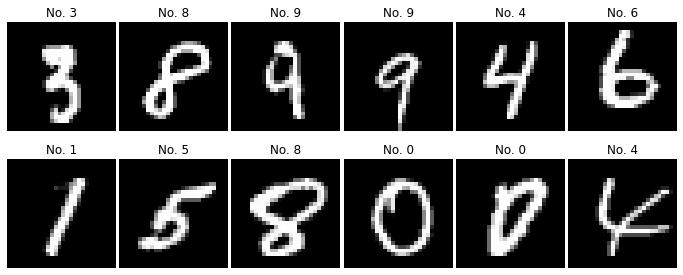

Augmented data:



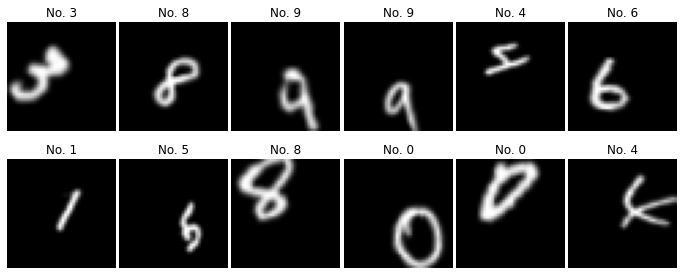

In [0]:
print("Original dataset:\n")
plot_imagesNlabels(train_x,train_label,"orig_images")
print("Augmented data:\n")
plot_imagesNlabels(train_data_1,train_label,"augmented_images")

Load the model and print the summary of our model.

In [0]:
model = STN_Model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
STN_Input (InputLayer)          [(None, 40, 40, 1)]  0                                            
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 20, 20, 1)    0           STN_Input[0][0]                  
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 16, 16, 20)   520         max_pooling2d[0][0]              
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 8, 8, 20)     0           conv2d[0][0]                     
______________________________________________________________________________________________

Run the following code to plot the model:

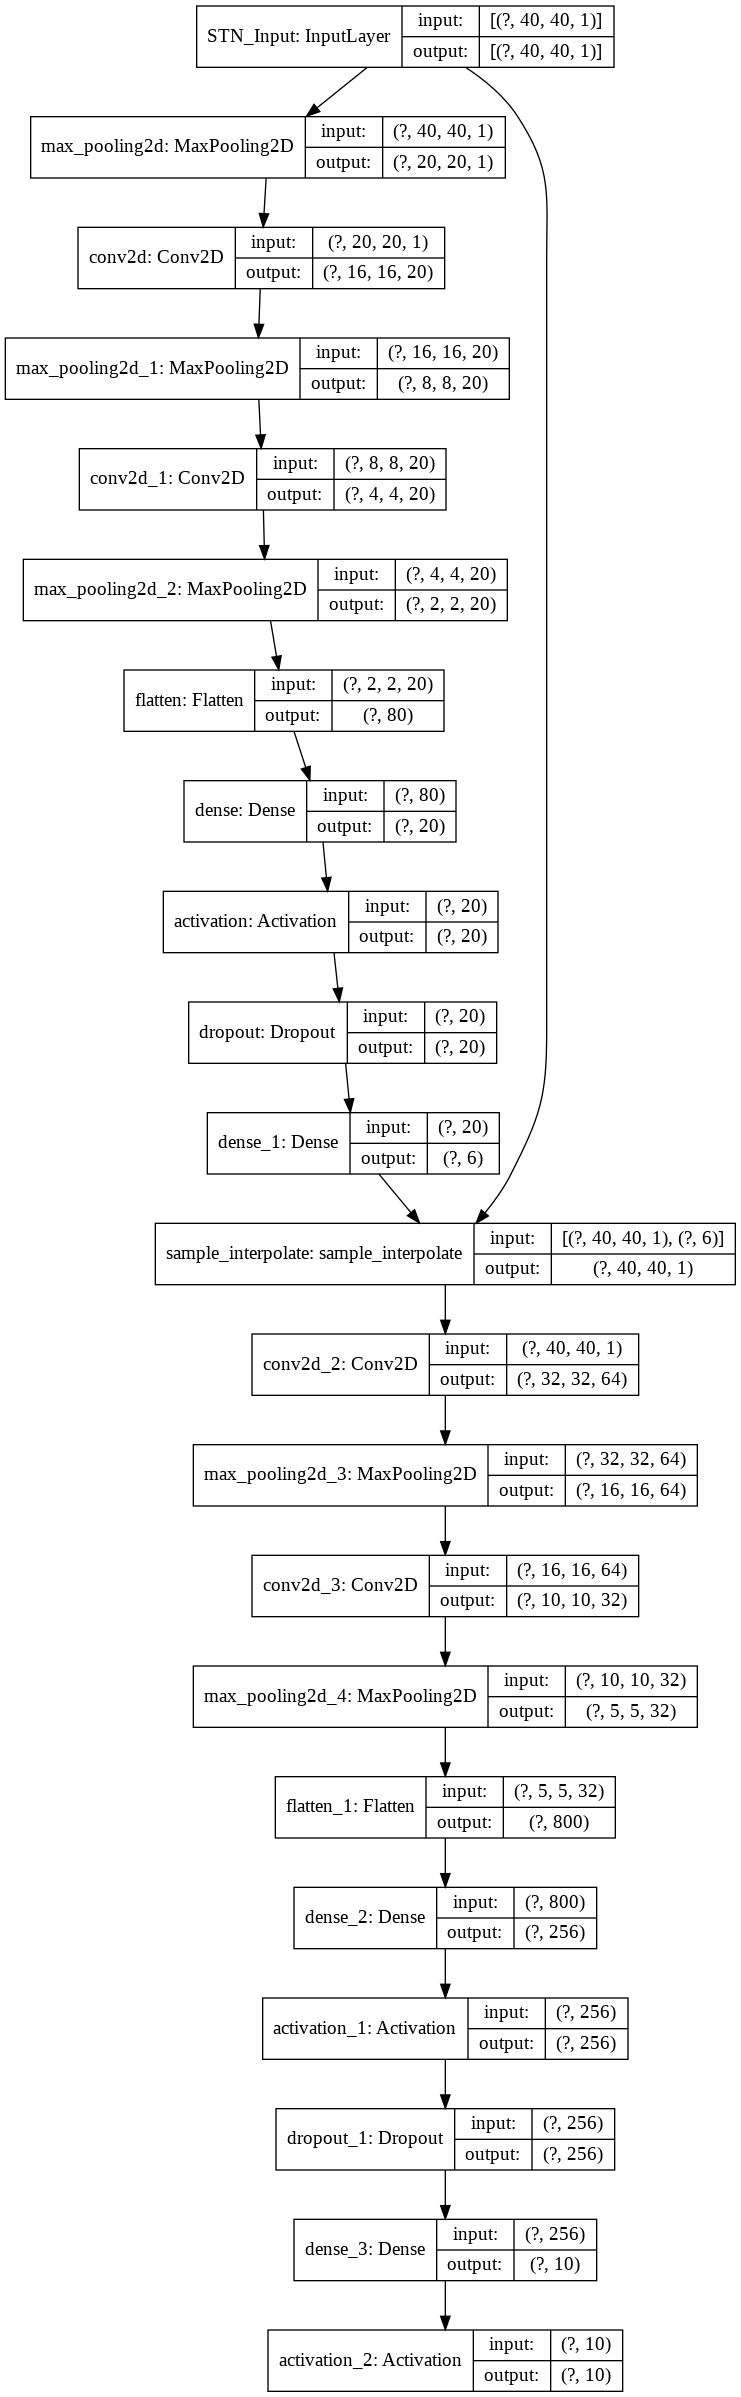

In [0]:
keras.utils.plot_model(model, 'STN.png', show_shapes=True)

Define a function to perform learning rate decay

In [0]:
def learning_decay(base_learning_rate, epoch_num, decay_rate):
  learning = []
  learning_rate = base_learning_rate/(1+(decay_rate*epoch_num))
  learning.append(learning_rate)
  return learning_rate

The following funtion trains and prints the results:

In [0]:
def train_STN(input_shape, num_classes, base_learning_rate=1e-2, batch_size = 64, num_epochs = 100, decay_rate = 0.09, l2_reg = 0.00, drop_rate = 0.00, batch_norm = 0, opti = 'sgd', print_steps = 200, print_freq = 1):
  # Call the model with parameters
  stn_model = STN_Model(input_shape=input_shape, num_classes=num_classes, reg=l2_reg, drop_rate=drop_rate, batch_norm=batch_norm)
  # define intermediate model to visualize the transformation
  stn_model.layers[11]._name='sample_interpolate'
  layer_output=stn_model.get_layer('sample_interpolate').output
  intermediate_model=tf.keras.models.Model(inputs=stn_model.input,outputs=layer_output)
  #define metrics
  train_acc_metric = keras.metrics.CategoricalAccuracy()
  val_acc_metric = keras.metrics.CategoricalAccuracy()
  test_acc_metric = keras.metrics.CategoricalAccuracy()
  batch_size = batch_size
  train_dataset = tf.data.Dataset.from_tensor_slices((train_data_1, train_label))
  train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

  #prepare val dataset
  val_dataset = tf.data.Dataset.from_tensor_slices((val_data_1, val_label))
  val_dataset = val_dataset.batch(64)

  #prepare test dataset
  test_dataset = tf.data.Dataset.from_tensor_slices((test_data_1, test_label))
  test_dataset = test_dataset.batch(64)

  costs = []
  costs_val = []
  epochs = num_epochs
  for epoch in range(epochs):
    learning_rate = learning_decay(base_learning_rate, epoch, decay_rate)
    # Instantiate an optimizer.
    if opti == 'adam':
      optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    if opti == 'sgd':
      optimizer = keras.optimizers.SGD(learning_rate=learning_rate)
    # Instantiate a loss function.
    loss_fn = keras.losses.CategoricalCrossentropy(from_logits=True)
    epoch_cost = 0
    print('Start of epoch %d' % (epoch,))
    # Iterate over the batches of the dataset.
    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
      #gradient tape records forward pass allowing the optimizer to perform back propagation
      with tf.GradientTape() as tape:
        #logits contain predicted value (output)
        logits = stn_model(x_batch_train, training=True)
        loss_value = loss_fn(y_batch_train, logits)
        epoch_cost += loss_value
      #retrieve the gradients
      grads = tape.gradient(loss_value, stn_model.trainable_weights)
      #update the weights and biases
      optimizer.apply_gradients(zip(grads, stn_model.trainable_weights))
      train_acc_metric.update_state(y_batch_train, logits)
      if step % print_steps == 0:
        print('Training loss (for one batch) at step %s: %s' % (step, float(loss_value)))
        print('Seen so far: %s samples' % ((step + 1) * batch_size))

    # Display metrics at the end of each epoch.
    train_acc = train_acc_metric.result()
    print('Training acc over epoch %i: %s' % (epoch, float(train_acc),))
    print ("Training Cost after epoch %i: %f" % (epoch, (epoch_cost*batch_size/(train_data_1.shape[0]))))
    #store the training costs over the epochs
    costs.append(epoch_cost*batch_size/(train_data_1.shape[0]))
    #print the output of transform layer

    #this part prints and saves the images in drive
    if epoch % print_freq == 0:
      intermediate_prediction=intermediate_model.predict(train_data_1)
      if l2_reg==0 and drop_rate==0 and batch_norm == 0:
        print('Inputs after transformation after epoch %i :\n' % epoch)
        plot_imagesNlabels(intermediate_prediction,train_label, fname = "/content/gdrive/My Drive/project/STN_NNFL/wo_reg_drop/transformation " + str(epoch))
      if l2_reg != 0 and drop_rate == 0:
        print('Inputs after transformation after epoch %i :\n' % epoch)
        plot_imagesNlabels(intermediate_prediction,train_label, fname = "/content/gdrive/My Drive/project/STN_NNFL/w_reg/transformation " + str(epoch))
      if l2_reg != 0 and drop_rate !=0:
        print('Inputs after transformation after epoch %i :\n' % epoch)
        plot_imagesNlabels(intermediate_prediction,train_label, fname = "/content/gdrive/My Drive/project/STN_NNFL/w_reg_drop/transformation " + str(epoch))
      if batch_norm != 0:
        print('Inputs after transformation after epoch %i :\n' % epoch)
        plot_imagesNlabels(intermediate_prediction,train_label, fname = "/content/gdrive/My Drive/project/STN_NNFL/w_batch_norm/transformation " + str(epoch))

    

    
    val_cost = 0
    # Run a validation loop at the end of each epoch.
    for x_batch_val, y_batch_val in val_dataset:
      val_logits = stn_model(x_batch_val)
      val_loss = loss_fn(y_batch_val, val_logits)
      val_cost += val_loss
      # Update val metrics
      val_acc_metric.update_state(y_batch_val, val_logits)
    #store the validation costs over the epochs
    costs_val.append(val_cost*64/(val_data_1.shape[0]))
    val_acc = val_acc_metric.result()
    
    print('Validation acc over epoch %i: %s' % (epoch, float(val_acc),))
    print ("Validation Cost after epoch %i: %f" % (epoch, (val_cost*64/(val_data_1.shape[0]))))

  # run the test data after completing training
  test_cost =0
  for x_batch_test, y_batch_test in test_dataset:
    test_logits = stn_model(x_batch_test,training=False)
    test_loss = loss_fn(y_batch_test, test_logits)
    test_cost += test_loss
    test_acc_metric.update_state(y_batch_test, test_logits)
  test_acc = test_acc_metric.result()
  print('test acc over epoch: %s' % (float(test_acc),))
  print("test Cost after epoch: %f" % ((test_cost*64/(test_data_1.shape[0]))))

  return stn_model, np.squeeze(costs), np.squeeze(costs_val)



Train the model without regularization, dropout, and batch normalization for 100 epochs 

Start of epoch 0
Training loss (for one batch) at step 0: 2.302581787109375
Seen so far: 256 samples
Training loss (for one batch) at step 100: 1.9331656694412231
Seen so far: 25856 samples
Training loss (for one batch) at step 200: 1.9746265411376953
Seen so far: 51456 samples
Training acc over epoch 0: 0.4361666738986969
Training Cost after epoch 0: 2.019411
Inputs after transformation after epoch 0 :



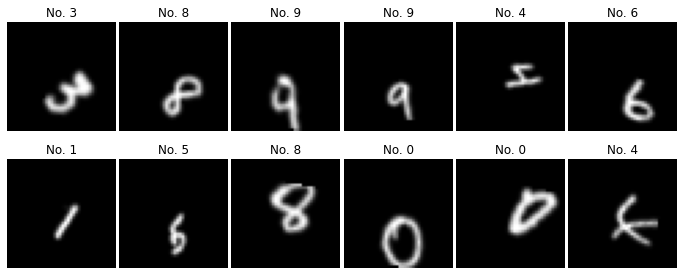

Validation acc over epoch 0: 0.5235000252723694
Validation Cost after epoch 0: 1.938893
Start of epoch 1
Training loss (for one batch) at step 0: 1.9486150741577148
Seen so far: 256 samples
Training loss (for one batch) at step 100: 1.8958778381347656
Seen so far: 25856 samples
Training loss (for one batch) at step 200: 1.9050185680389404
Seen so far: 51456 samples
Training acc over epoch 1: 0.5109537243843079
Training Cost after epoch 1: 1.873807
Validation acc over epoch 1: 0.5715833306312561
Validation Cost after epoch 1: 1.843095
Start of epoch 2
Training loss (for one batch) at step 0: 1.8559770584106445
Seen so far: 256 samples
Training loss (for one batch) at step 100: 1.837937593460083
Seen so far: 25856 samples
Training loss (for one batch) at step 200: 1.800000786781311
Seen so far: 51456 samples
Training acc over epoch 2: 0.5548827052116394
Training Cost after epoch 2: 1.818045
Validation acc over epoch 2: 0.5822222232818604
Validation Cost after epoch 2: 1.861144
Start of e

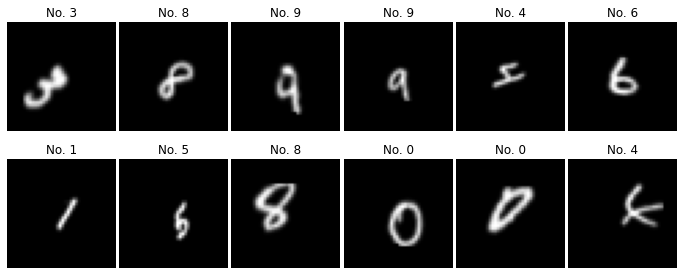

Validation acc over epoch 10: 0.6711817979812622
Validation Cost after epoch 10: 1.713946
Start of epoch 11
Training loss (for one batch) at step 0: 1.690913438796997
Seen so far: 256 samples
Training loss (for one batch) at step 100: 1.649503231048584
Seen so far: 25856 samples
Training loss (for one batch) at step 200: 1.7024673223495483
Seen so far: 51456 samples
Training acc over epoch 11: 0.678560197353363
Training Cost after epoch 11: 1.689716
Validation acc over epoch 11: 0.6782916784286499
Validation Cost after epoch 11: 1.709274
Start of epoch 12
Training loss (for one batch) at step 0: 1.6796586513519287
Seen so far: 256 samples
Training loss (for one batch) at step 100: 1.6743937730789185
Seen so far: 25856 samples
Training loss (for one batch) at step 200: 1.9275434017181396
Seen so far: 51456 samples
Training acc over epoch 12: 0.6834231019020081
Training Cost after epoch 12: 1.719419
Validation acc over epoch 12: 0.6751794815063477
Validation Cost after epoch 12: 1.827329

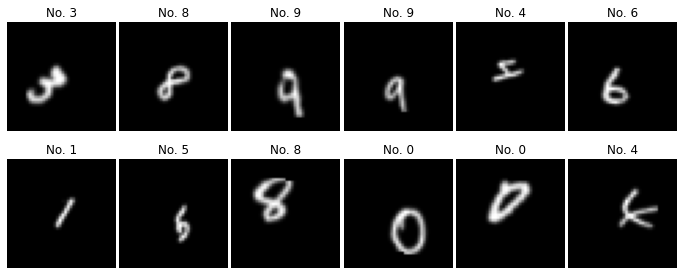

Validation acc over epoch 20: 0.7155476212501526
Validation Cost after epoch 20: 1.668289
Start of epoch 21
Training loss (for one batch) at step 0: 1.6875883340835571
Seen so far: 256 samples
Training loss (for one batch) at step 100: 1.6524207592010498
Seen so far: 25856 samples
Training loss (for one batch) at step 200: 1.6915202140808105
Seen so far: 51456 samples
Training acc over epoch 21: 0.7232457995414734
Training Cost after epoch 21: 1.668432
Validation acc over epoch 21: 0.718765139579773
Validation Cost after epoch 21: 1.678923
Start of epoch 22
Training loss (for one batch) at step 0: 1.6405830383300781
Seen so far: 256 samples
Training loss (for one batch) at step 100: 1.7449263334274292
Seen so far: 25856 samples
Training loss (for one batch) at step 200: 1.7278512716293335
Seen so far: 51456 samples
Training acc over epoch 22: 0.7236143350601196
Training Cost after epoch 22: 1.729556
Validation acc over epoch 22: 0.7200434803962708
Validation Cost after epoch 22: 1.7172

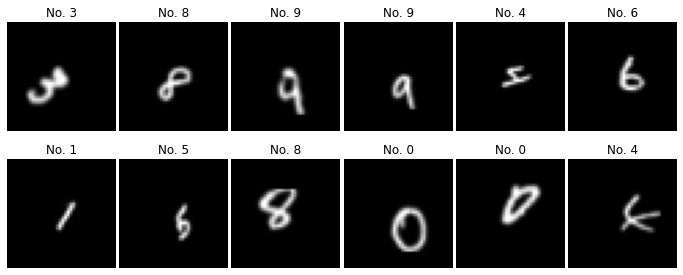

Validation acc over epoch 30: 0.7368226051330566
Validation Cost after epoch 30: 1.664131
Start of epoch 31
Training loss (for one batch) at step 0: 1.6520617008209229
Seen so far: 256 samples
Training loss (for one batch) at step 100: 1.6253268718719482
Seen so far: 25856 samples
Training loss (for one batch) at step 200: 1.6953916549682617
Seen so far: 51456 samples
Training acc over epoch 31: 0.7431753277778625
Training Cost after epoch 31: 1.671597
Validation acc over epoch 31: 0.7381770610809326
Validation Cost after epoch 31: 1.685016
Start of epoch 32
Training loss (for one batch) at step 0: 1.656079649925232
Seen so far: 256 samples
Training loss (for one batch) at step 100: 1.6792206764221191
Seen so far: 25856 samples
Training loss (for one batch) at step 200: 1.6571701765060425
Seen so far: 51456 samples
Training acc over epoch 32: 0.7449668645858765
Training Cost after epoch 32: 1.659153
Validation acc over epoch 32: 0.7399141192436218
Validation Cost after epoch 32: 1.6703

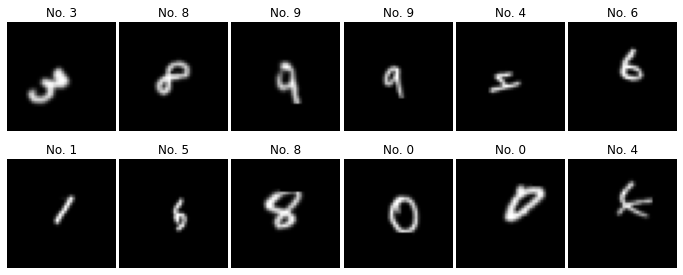

Validation acc over epoch 40: 0.7507236003875732
Validation Cost after epoch 40: 1.657699
Start of epoch 41
Training loss (for one batch) at step 0: 1.6482996940612793
Seen so far: 256 samples
Training loss (for one batch) at step 100: 1.6134536266326904
Seen so far: 25856 samples
Training loss (for one batch) at step 200: 1.6332283020019531
Seen so far: 51456 samples
Training acc over epoch 41: 0.7580193877220154
Training Cost after epoch 41: 1.642089
Validation acc over epoch 41: 0.7522579431533813
Validation Cost after epoch 41: 1.650850
Start of epoch 42
Training loss (for one batch) at step 0: 1.6288255453109741
Seen so far: 256 samples
Training loss (for one batch) at step 100: 1.6084023714065552
Seen so far: 25856 samples
Training loss (for one batch) at step 200: 1.6348918676376343
Seen so far: 51456 samples
Training acc over epoch 42: 0.7594130039215088
Training Cost after epoch 42: 1.643420
Validation acc over epoch 42: 0.7537480592727661
Validation Cost after epoch 42: 1.648

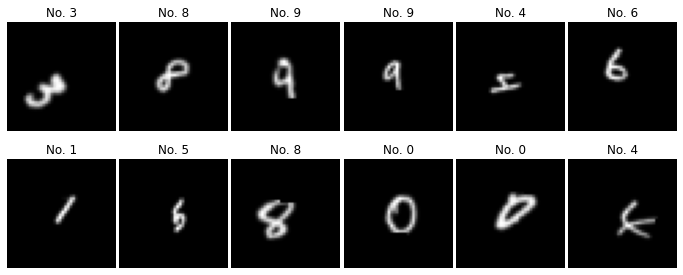

Validation acc over epoch 50: 0.762676477432251
Validation Cost after epoch 50: 1.651851
Start of epoch 51
Training loss (for one batch) at step 0: 1.6330373287200928
Seen so far: 256 samples
Training loss (for one batch) at step 100: 1.6252026557922363
Seen so far: 25856 samples
Training loss (for one batch) at step 200: 1.6526710987091064
Seen so far: 51456 samples
Training acc over epoch 51: 0.7696641683578491
Training Cost after epoch 51: 1.634205
Validation acc over epoch 51: 0.7636730670928955
Validation Cost after epoch 51: 1.651065
Start of epoch 52
Training loss (for one batch) at step 0: 1.6028214693069458
Seen so far: 256 samples
Training loss (for one batch) at step 100: 1.5978621244430542
Seen so far: 25856 samples
Training loss (for one batch) at step 200: 1.641499638557434
Seen so far: 51456 samples
Training acc over epoch 52: 0.7707826495170593
Training Cost after epoch 52: 1.632598
Validation acc over epoch 52: 0.7645629048347473
Validation Cost after epoch 52: 1.65467

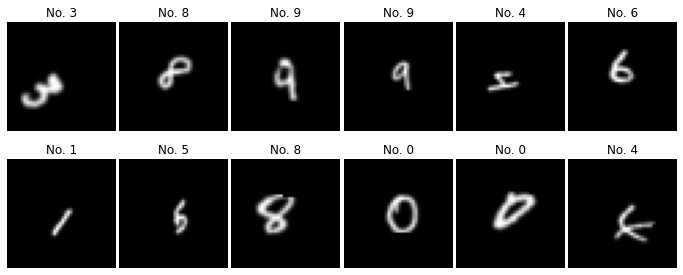

Validation acc over epoch 60: 0.7720491886138916
Validation Cost after epoch 60: 1.646928
Start of epoch 61
Training loss (for one batch) at step 0: 1.6455128192901611
Seen so far: 256 samples
Training loss (for one batch) at step 100: 1.6635271310806274
Seen so far: 25856 samples
Training loss (for one batch) at step 200: 1.6383380889892578
Seen so far: 51456 samples
Training acc over epoch 61: 0.7791334986686707
Training Cost after epoch 61: 1.630967
Validation acc over epoch 61: 0.77276611328125
Validation Cost after epoch 61: 1.649093
Start of epoch 62
Training loss (for one batch) at step 0: 1.6408027410507202
Seen so far: 256 samples
Training loss (for one batch) at step 100: 1.6407784223556519
Seen so far: 25856 samples
Training loss (for one batch) at step 200: 1.664208173751831
Seen so far: 51456 samples
Training acc over epoch 62: 0.7798377275466919
Training Cost after epoch 62: 1.637897
Validation acc over epoch 62: 0.7735158801078796
Validation Cost after epoch 62: 1.645547

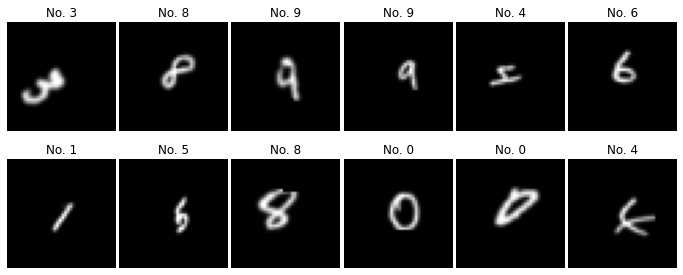

Validation acc over epoch 70: 0.7788591384887695
Validation Cost after epoch 70: 1.638158
Start of epoch 71
Training loss (for one batch) at step 0: 1.6133153438568115
Seen so far: 256 samples
Training loss (for one batch) at step 100: 1.60563325881958
Seen so far: 25856 samples
Training loss (for one batch) at step 200: 1.6095157861709595
Seen so far: 51456 samples
Training acc over epoch 71: 0.7861522436141968
Training Cost after epoch 71: 1.623826
Validation acc over epoch 71: 0.7794259190559387
Validation Cost after epoch 71: 1.645416
Start of epoch 72
Training loss (for one batch) at step 0: 1.6074018478393555
Seen so far: 256 samples
Training loss (for one batch) at step 100: 1.637384295463562
Seen so far: 25856 samples
Training loss (for one batch) at step 200: 1.6572415828704834
Seen so far: 51456 samples
Training acc over epoch 72: 0.7868214249610901
Training Cost after epoch 72: 1.626503
Validation acc over epoch 72: 0.7799589037895203
Validation Cost after epoch 72: 1.646795

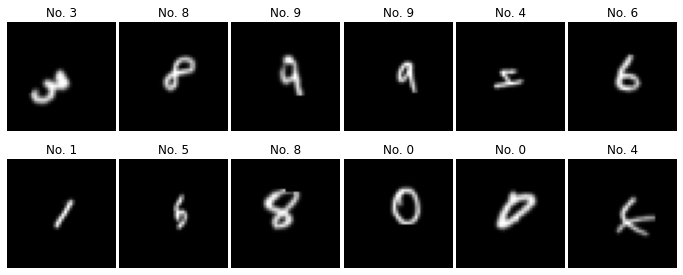

Validation acc over epoch 80: 0.7847962975502014
Validation Cost after epoch 80: 1.637624
Start of epoch 81
Training loss (for one batch) at step 0: 1.6234126091003418
Seen so far: 256 samples
Training loss (for one batch) at step 100: 1.6159617900848389
Seen so far: 25856 samples
Training loss (for one batch) at step 200: 1.6288971900939941
Seen so far: 51456 samples
Training acc over epoch 81: 0.7925431132316589
Training Cost after epoch 81: 1.622540
Validation acc over epoch 81: 0.7853719592094421
Validation Cost after epoch 81: 1.633697
Start of epoch 82
Training loss (for one batch) at step 0: 1.6213330030441284
Seen so far: 256 samples
Training loss (for one batch) at step 100: 1.6096065044403076
Seen so far: 25856 samples
Training loss (for one batch) at step 200: 1.6056574583053589
Seen so far: 51456 samples
Training acc over epoch 82: 0.7930548787117004
Training Cost after epoch 82: 1.626525
Validation acc over epoch 82: 0.785835325717926
Validation Cost after epoch 82: 1.6414

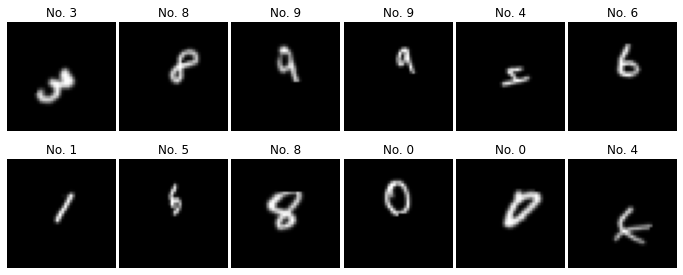

Validation acc over epoch 90: 0.7891117334365845
Validation Cost after epoch 90: 1.652920
Start of epoch 91
Training loss (for one batch) at step 0: 1.646436095237732
Seen so far: 256 samples
Training loss (for one batch) at step 100: 1.7045252323150635
Seen so far: 25856 samples
Training loss (for one batch) at step 200: 1.634208083152771
Seen so far: 51456 samples
Training acc over epoch 91: 0.7965062260627747
Training Cost after epoch 91: 1.655877
Validation acc over epoch 91: 0.7893840670585632
Validation Cost after epoch 91: 1.651127
Start of epoch 92
Training loss (for one batch) at step 0: 1.6422139406204224
Seen so far: 256 samples
Training loss (for one batch) at step 100: 1.6453430652618408
Seen so far: 25856 samples
Training loss (for one batch) at step 200: 1.6534732580184937
Seen so far: 51456 samples
Training acc over epoch 92: 0.796964168548584
Training Cost after epoch 92: 1.622458
Validation acc over epoch 92: 0.7898620367050171
Validation Cost after epoch 92: 1.631928

In [0]:
stn_model,train_cost,val_cost = train_STN(input_shape = input_shape, num_classes = num_classes, base_learning_rate=1e-2, batch_size = 256, num_epochs = 100, decay_rate = 0.09, l2_reg = 0.00, drop_rate = 0.00, batch_norm = 0, opti = 'adam', print_steps = 100, print_freq = 10)

The following function plots train and validation costs

In [0]:
def plot_costs(num_epochs, train_cost, val_cost,filename):
  # plot the training cost
  x = np.arange(0, num_epochs, 1)
  fig, ax = plt.subplots()
  ax.plot(x, train_cost, 'b', label='train cost')
  ax.plot(x, val_cost, 'r', label='validation cost')
  leg = ax.legend()
  plt.ylabel('cost')
  plt.xlabel('epochs')
  plt.title("Training and validation cost")
  fig.savefig(filename)
  plt.show()

  # plot the val cost
  #plt.plot(np.squeeze(costs_val))
  #plt.ylabel('cost')
  #plt.xlabel('epochs')
  #plt.title("Validation cost")
  #plt.show()

Plot the costs for the model trained without dropout and regularization, and batch normalization.

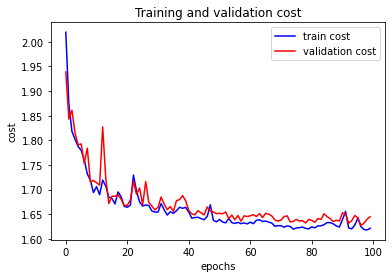

In [61]:
plot_costs(100,train_cost,val_cost,"costs_wo_drop_reg")

In [0]:
ls

augmentation.py        samplerNinterpolation.py  transformation5.png
augmented_images.png   STN_NNFL/                 transformation6.png
costs_wo_drop_reg.png  STN_NNFL.ipynb            transformation7.png
costs_w_reg.png        STN.png                   transformation8.png
mnist_keras_load.py    transformation0.png       transformation9.png
model.py               transformation1.png       utils.py
orig_images.png        transformation2.png       wo_reg_drop/
__pycache__/           transformation3.png       w_reg/
README.md              transformation4.png       w_reg_drop/


Train the model with l2 regularization for 100 epochs to prevent overfitting.

Start of epoch 0
Training loss (for one batch) at step 0: 2.3032476902008057
Seen so far: 256 samples
Training loss (for one batch) at step 100: 2.0826005935668945
Seen so far: 25856 samples
Training loss (for one batch) at step 200: 2.0434324741363525
Seen so far: 51456 samples
Training acc over epoch 0: 0.3269444406032562
Training Cost after epoch 0: 2.121918
Inputs after transformation after epoch 0 :



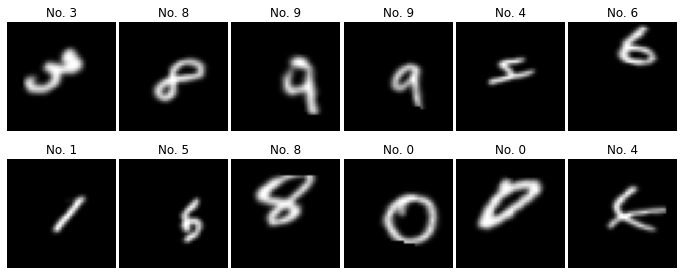

Validation acc over epoch 0: 0.43816667795181274
Validation Cost after epoch 0: 2.025892
Start of epoch 1
Training loss (for one batch) at step 0: 2.033090829849243
Seen so far: 256 samples
Training loss (for one batch) at step 100: 1.8924401998519897
Seen so far: 25856 samples
Training loss (for one batch) at step 200: 1.7829238176345825
Seen so far: 51456 samples
Training acc over epoch 1: 0.4475555419921875
Training Cost after epoch 1: 1.890761
Validation acc over epoch 1: 0.5573333501815796
Validation Cost after epoch 1: 1.788510
Start of epoch 2
Training loss (for one batch) at step 0: 1.797879695892334
Seen so far: 256 samples
Training loss (for one batch) at step 100: 1.682080626487732
Seen so far: 25856 samples
Training loss (for one batch) at step 200: 1.7795873880386353
Seen so far: 51456 samples
Training acc over epoch 2: 0.5401296019554138
Training Cost after epoch 2: 1.735556
Validation acc over epoch 2: 0.6154444217681885
Validation Cost after epoch 2: 1.732433
Start of e

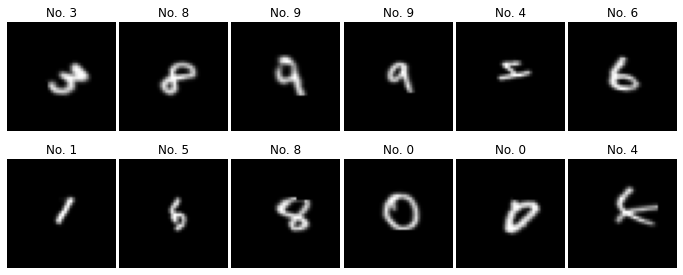

Validation acc over epoch 10: 0.7608484625816345
Validation Cost after epoch 10: 1.636723
Start of epoch 11
Training loss (for one batch) at step 0: 1.6261703968048096
Seen so far: 256 samples
Training loss (for one batch) at step 100: 1.62699556350708
Seen so far: 25856 samples
Training loss (for one batch) at step 200: 1.6715409755706787
Seen so far: 51456 samples
Training acc over epoch 11: 0.7474737763404846
Training Cost after epoch 11: 1.613382
Validation acc over epoch 11: 0.7665416598320007
Validation Cost after epoch 11: 1.636480
Start of epoch 12
Training loss (for one batch) at step 0: 1.622614860534668
Seen so far: 256 samples
Training loss (for one batch) at step 100: 1.6394786834716797
Seen so far: 25856 samples
Training loss (for one batch) at step 200: 1.6130354404449463
Seen so far: 51456 samples
Training acc over epoch 12: 0.7552093863487244
Training Cost after epoch 12: 1.612944
Validation acc over epoch 12: 0.7739743590354919
Validation Cost after epoch 12: 1.601392

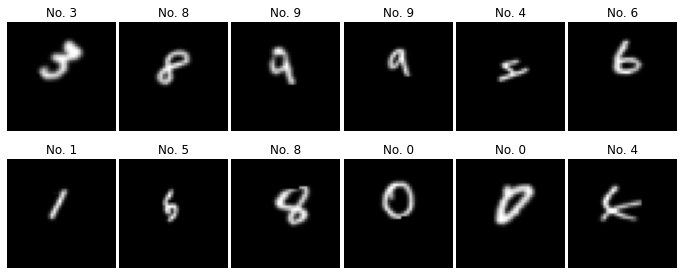

Validation acc over epoch 20: 0.8033174872398376
Validation Cost after epoch 20: 1.625587
Start of epoch 21
Training loss (for one batch) at step 0: 1.5960801839828491
Seen so far: 256 samples
Training loss (for one batch) at step 100: 1.6279646158218384
Seen so far: 25856 samples
Training loss (for one batch) at step 200: 1.6188971996307373
Seen so far: 51456 samples
Training acc over epoch 21: 0.7999520301818848
Training Cost after epoch 21: 1.592600
Validation acc over epoch 21: 0.8069697022438049
Validation Cost after epoch 21: 1.581446
Start of epoch 22
Training loss (for one batch) at step 0: 1.580793857574463
Seen so far: 256 samples
Training loss (for one batch) at step 100: 1.5663142204284668
Seen so far: 25856 samples
Training loss (for one batch) at step 200: 1.5945450067520142
Seen so far: 51456 samples
Training acc over epoch 22: 0.8035193085670471
Training Cost after epoch 22: 1.579371
Validation acc over epoch 22: 0.8099492788314819
Validation Cost after epoch 22: 1.5896

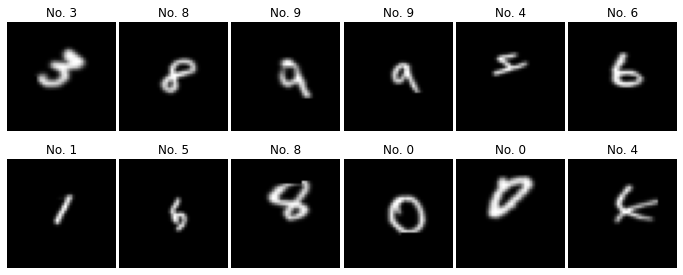

Validation acc over epoch 30: 0.8283763527870178
Validation Cost after epoch 30: 1.574497
Start of epoch 31
Training loss (for one batch) at step 0: 1.5627391338348389
Seen so far: 256 samples
Training loss (for one batch) at step 100: 1.583614706993103
Seen so far: 25856 samples
Training loss (for one batch) at step 200: 1.6165951490402222
Seen so far: 51456 samples
Training acc over epoch 31: 0.826953113079071
Training Cost after epoch 31: 1.584952
Validation acc over epoch 31: 0.828906238079071
Validation Cost after epoch 31: 1.619585
Start of epoch 32
Training loss (for one batch) at step 0: 1.6221044063568115
Seen so far: 256 samples
Training loss (for one batch) at step 100: 1.5496906042099
Seen so far: 25856 samples
Training loss (for one batch) at step 200: 1.581455945968628
Seen so far: 51456 samples
Training acc over epoch 32: 0.828856348991394
Training Cost after epoch 32: 1.571667
Validation acc over epoch 32: 0.8307929039001465
Validation Cost after epoch 32: 1.574197
Star

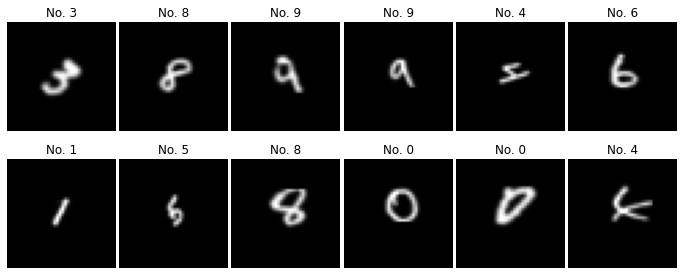

Validation acc over epoch 40: 0.8425202965736389
Validation Cost after epoch 40: 1.553830
Start of epoch 41
Training loss (for one batch) at step 0: 1.5371743440628052
Seen so far: 256 samples
Training loss (for one batch) at step 100: 1.5216273069381714
Seen so far: 25856 samples
Training loss (for one batch) at step 200: 1.576256275177002
Seen so far: 51456 samples
Training acc over epoch 41: 0.843377411365509
Training Cost after epoch 41: 1.556497
Validation acc over epoch 41: 0.8437539935112
Validation Cost after epoch 41: 1.570742
Start of epoch 42
Training loss (for one batch) at step 0: 1.582777738571167
Seen so far: 256 samples
Training loss (for one batch) at step 100: 1.5514880418777466
Seen so far: 25856 samples
Training loss (for one batch) at step 200: 1.5391745567321777
Seen so far: 51456 samples
Training acc over epoch 42: 0.8447076082229614
Training Cost after epoch 42: 1.560792
Validation acc over epoch 42: 0.8452519178390503
Validation Cost after epoch 42: 1.557058
St

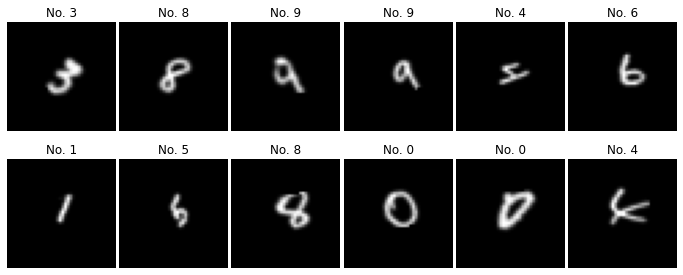

Validation acc over epoch 50: 0.8535817265510559
Validation Cost after epoch 50: 1.559462
Start of epoch 51
Training loss (for one batch) at step 0: 1.5403339862823486
Seen so far: 256 samples
Training loss (for one batch) at step 100: 1.5708975791931152
Seen so far: 25856 samples
Training loss (for one batch) at step 200: 1.5559101104736328
Seen so far: 51456 samples
Training acc over epoch 51: 0.854798436164856
Training Cost after epoch 51: 1.559550
Validation acc over epoch 51: 0.8545032143592834
Validation Cost after epoch 51: 1.563866
Start of epoch 52
Training loss (for one batch) at step 0: 1.5536922216415405
Seen so far: 256 samples
Training loss (for one batch) at step 100: 1.5272736549377441
Seen so far: 25856 samples
Training loss (for one batch) at step 200: 1.5738697052001953
Seen so far: 51456 samples
Training acc over epoch 52: 0.8559322357177734
Training Cost after epoch 52: 1.546526
Validation acc over epoch 52: 0.8555031418800354
Validation Cost after epoch 52: 1.5575

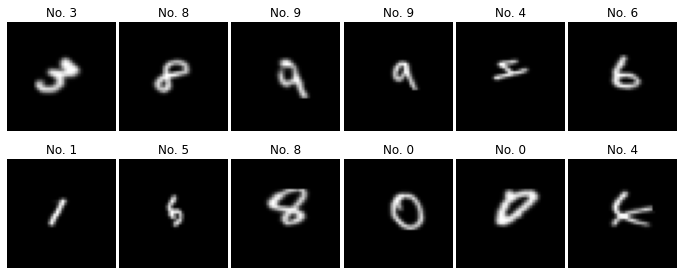

Validation acc over epoch 60: 0.8624672293663025
Validation Cost after epoch 60: 1.552480
Start of epoch 61
Training loss (for one batch) at step 0: 1.542982578277588
Seen so far: 256 samples
Training loss (for one batch) at step 100: 1.5281774997711182
Seen so far: 25856 samples
Training loss (for one batch) at step 200: 1.5668277740478516
Seen so far: 51456 samples
Training acc over epoch 61: 0.8641409873962402
Training Cost after epoch 61: 1.551458
Validation acc over epoch 61: 0.8630940914154053
Validation Cost after epoch 61: 1.563828
Start of epoch 62
Training loss (for one batch) at step 0: 1.5698038339614868
Seen so far: 256 samples
Training loss (for one batch) at step 100: 1.5627367496490479
Seen so far: 25856 samples
Training loss (for one batch) at step 200: 1.5162547826766968
Seen so far: 51456 samples
Training acc over epoch 62: 0.8649629354476929
Training Cost after epoch 62: 1.545606
Validation acc over epoch 62: 0.8638253808021545
Validation Cost after epoch 62: 1.5561

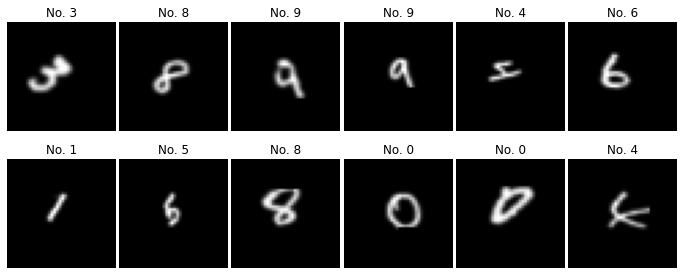

Validation acc over epoch 70: 0.8689718246459961
Validation Cost after epoch 70: 1.555829
Start of epoch 71
Training loss (for one batch) at step 0: 1.5389307737350464
Seen so far: 256 samples
Training loss (for one batch) at step 100: 1.5729905366897583
Seen so far: 25856 samples
Training loss (for one batch) at step 200: 1.5333313941955566
Seen so far: 51456 samples
Training acc over epoch 71: 0.8717294335365295
Training Cost after epoch 71: 1.544379
Validation acc over epoch 71: 0.8694027662277222
Validation Cost after epoch 71: 1.565283
Start of epoch 72
Training loss (for one batch) at step 0: 1.5377360582351685
Seen so far: 256 samples
Training loss (for one batch) at step 100: 1.5314711332321167
Seen so far: 25856 samples
Training loss (for one batch) at step 200: 1.5686241388320923
Seen so far: 51456 samples
Training acc over epoch 72: 0.8723483085632324
Training Cost after epoch 72: 1.544682
Validation acc over epoch 72: 0.8698607087135315
Validation Cost after epoch 72: 1.562

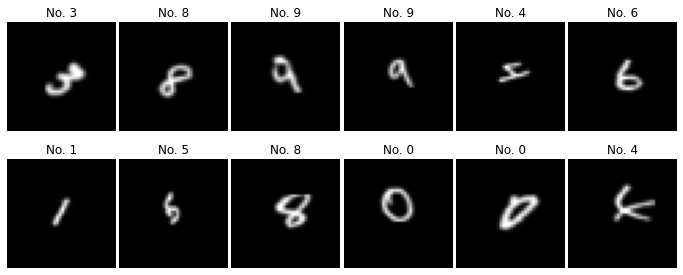

Validation acc over epoch 80: 0.8744177222251892
Validation Cost after epoch 80: 1.557353
Start of epoch 81
Training loss (for one batch) at step 0: 1.5155354738235474
Seen so far: 256 samples
Training loss (for one batch) at step 100: 1.5437867641448975
Seen so far: 25856 samples
Training loss (for one batch) at step 200: 1.523876428604126
Seen so far: 51456 samples
Training acc over epoch 81: 0.8778750896453857
Training Cost after epoch 81: 1.540559
Validation acc over epoch 81: 0.8749857544898987
Validation Cost after epoch 81: 1.544131
Start of epoch 82
Training loss (for one batch) at step 0: 1.5193227529525757
Seen so far: 256 samples
Training loss (for one batch) at step 100: 1.5484352111816406
Seen so far: 25856 samples
Training loss (for one batch) at step 200: 1.5500319004058838
Seen so far: 51456 samples
Training acc over epoch 82: 0.8784763216972351
Training Cost after epoch 82: 1.533754
Validation acc over epoch 82: 0.875538170337677
Validation Cost after epoch 82: 1.54415

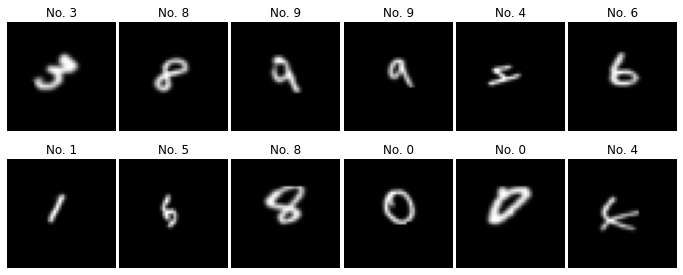

Validation acc over epoch 90: 0.8792179226875305
Validation Cost after epoch 90: 1.549847
Start of epoch 91
Training loss (for one batch) at step 0: 1.5353704690933228
Seen so far: 256 samples
Training loss (for one batch) at step 100: 1.5151869058609009
Seen so far: 25856 samples
Training loss (for one batch) at step 200: 1.547037124633789
Seen so far: 51456 samples
Training acc over epoch 91: 0.8834097981452942
Training Cost after epoch 91: 1.527110
Validation acc over epoch 91: 0.8797228336334229
Validation Cost after epoch 91: 1.539525
Start of epoch 92
Training loss (for one batch) at step 0: 1.5002249479293823
Seen so far: 256 samples
Training loss (for one batch) at step 100: 1.5632193088531494
Seen so far: 25856 samples
Training loss (for one batch) at step 200: 1.5468077659606934
Seen so far: 51456 samples
Training acc over epoch 92: 0.8838905096054077
Training Cost after epoch 92: 1.533329
Validation acc over epoch 92: 0.8800286650657654
Validation Cost after epoch 92: 1.5573

In [71]:
stn_model_reg,train_cost_reg,val_cost_reg = train_STN(input_shape = input_shape, num_classes = num_classes, base_learning_rate=1e-2, batch_size = 256, num_epochs = 100, decay_rate = 0.09, l2_reg = 0.001, drop_rate = 0.00, batch_norm = 0, opti = 'adam', print_steps = 100, print_freq = 10)

Plot the costs for the model trained with regularization

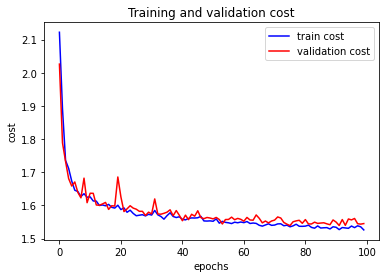

In [72]:
plot_costs(100,train_cost_reg,val_cost_reg,"costs_w_reg")

Train the model with regularization lambda = 0.01 and dropout rate = 0.2 for 100 epochs to prevent overfitting

Start of epoch 0
Training loss (for one batch) at step 0: 2.3025014400482178
Seen so far: 256 samples
Training loss (for one batch) at step 100: 1.9838210344314575
Seen so far: 25856 samples
Training loss (for one batch) at step 200: 1.7768594026565552
Seen so far: 51456 samples
Training acc over epoch 0: 0.4673703610897064
Training Cost after epoch 0: 1.985132
Inputs after transformation after epoch 0 :



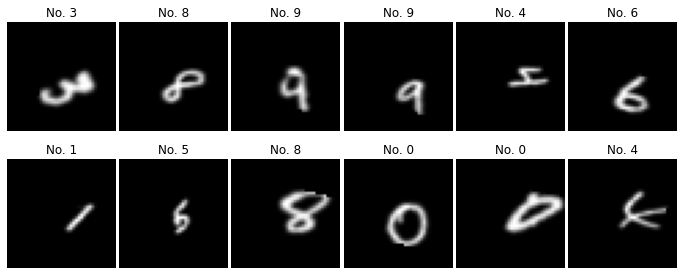

Validation acc over epoch 0: 0.6801666617393494
Validation Cost after epoch 0: 1.784888
Start of epoch 1
Training loss (for one batch) at step 0: 1.7618725299835205
Seen so far: 256 samples
Training loss (for one batch) at step 100: 1.7046418190002441
Seen so far: 25856 samples
Training loss (for one batch) at step 200: 1.7545663118362427
Seen so far: 51456 samples
Training acc over epoch 1: 0.5929536819458008
Training Cost after epoch 1: 1.742606
Validation acc over epoch 1: 0.7037500143051147
Validation Cost after epoch 1: 1.737193
Start of epoch 2
Training loss (for one batch) at step 0: 1.7153340578079224
Seen so far: 256 samples
Training loss (for one batch) at step 100: 1.6920065879821777
Seen so far: 25856 samples
Training loss (for one batch) at step 200: 1.7253072261810303
Seen so far: 51456 samples
Training acc over epoch 2: 0.6468580365180969
Training Cost after epoch 2: 1.706149
Validation acc over epoch 2: 0.7293888926506042
Validation Cost after epoch 2: 1.682388
Start of

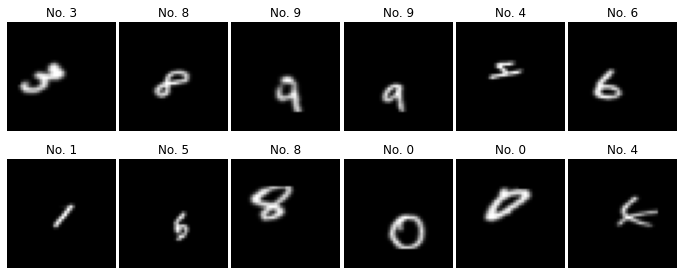

Validation acc over epoch 10: 0.7878788113594055
Validation Cost after epoch 10: 1.627984
Start of epoch 11
Training loss (for one batch) at step 0: 1.5831166505813599
Seen so far: 256 samples
Training loss (for one batch) at step 100: 1.6452832221984863
Seen so far: 25856 samples
Training loss (for one batch) at step 200: 1.6605793237686157
Seen so far: 51456 samples
Training acc over epoch 11: 0.7744166851043701
Training Cost after epoch 11: 1.631858
Validation acc over epoch 11: 0.7892916798591614
Validation Cost after epoch 11: 1.660415
Start of epoch 12
Training loss (for one batch) at step 0: 1.6149884462356567
Seen so far: 256 samples
Training loss (for one batch) at step 100: 1.626274824142456
Seen so far: 25856 samples
Training loss (for one batch) at step 200: 1.6379189491271973
Seen so far: 51456 samples
Training acc over epoch 12: 0.7792834639549255
Training Cost after epoch 12: 1.623451
Validation acc over epoch 12: 0.7922179698944092
Validation Cost after epoch 12: 1.6382

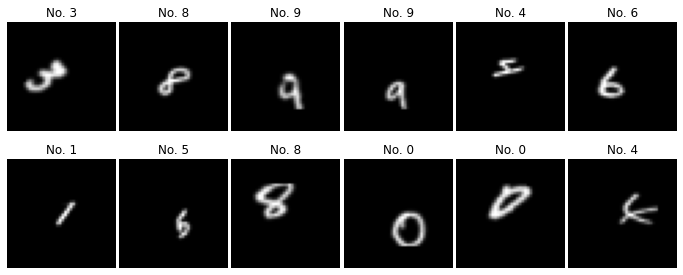

Validation acc over epoch 20: 0.8110079169273376
Validation Cost after epoch 20: 1.621748
Start of epoch 21
Training loss (for one batch) at step 0: 1.6380615234375
Seen so far: 256 samples
Training loss (for one batch) at step 100: 1.5700370073318481
Seen so far: 25856 samples
Training loss (for one batch) at step 200: 1.5747764110565186
Seen so far: 51456 samples
Training acc over epoch 21: 0.8105067610740662
Training Cost after epoch 21: 1.593097
Validation acc over epoch 21: 0.8119545578956604
Validation Cost after epoch 21: 1.633179
Start of epoch 22
Training loss (for one batch) at step 0: 1.6161574125289917
Seen so far: 256 samples
Training loss (for one batch) at step 100: 1.6050690412521362
Seen so far: 25856 samples
Training loss (for one batch) at step 200: 1.58184015750885
Seen so far: 51456 samples
Training acc over epoch 22: 0.8130813241004944
Training Cost after epoch 22: 1.591517
Validation acc over epoch 22: 0.8140217661857605
Validation Cost after epoch 22: 1.605416
S

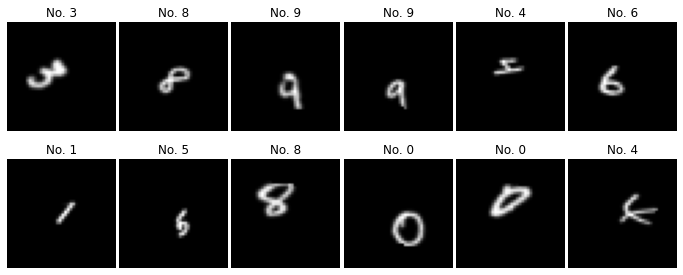

Validation acc over epoch 30: 0.8266935348510742
Validation Cost after epoch 30: 1.593272
Start of epoch 31
Training loss (for one batch) at step 0: 1.5507372617721558
Seen so far: 256 samples
Training loss (for one batch) at step 100: 1.5748844146728516
Seen so far: 25856 samples
Training loss (for one batch) at step 200: 1.5416141748428345
Seen so far: 51456 samples
Training acc over epoch 31: 0.8313964009284973
Training Cost after epoch 31: 1.580119
Validation acc over epoch 31: 0.8276093602180481
Validation Cost after epoch 31: 1.609194
Start of epoch 32
Training loss (for one batch) at step 0: 1.585801124572754
Seen so far: 256 samples
Training loss (for one batch) at step 100: 1.5938410758972168
Seen so far: 25856 samples
Training loss (for one batch) at step 200: 1.6316587924957275
Seen so far: 51456 samples
Training acc over epoch 32: 0.8329309821128845
Training Cost after epoch 32: 1.579386
Validation acc over epoch 32: 0.8284394145011902
Validation Cost after epoch 32: 1.6101

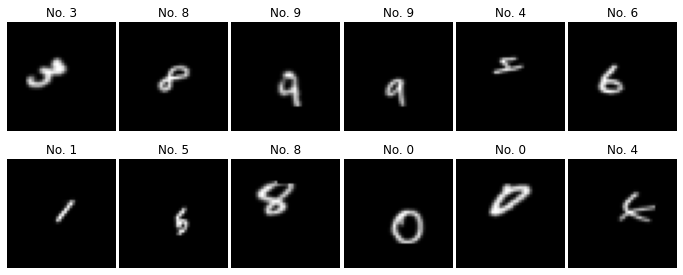

Validation acc over epoch 40: 0.8371788859367371
Validation Cost after epoch 40: 1.586864
Start of epoch 41
Training loss (for one batch) at step 0: 1.5413857698440552
Seen so far: 256 samples
Training loss (for one batch) at step 100: 1.561309576034546
Seen so far: 25856 samples
Training loss (for one batch) at step 200: 1.5587222576141357
Seen so far: 51456 samples
Training acc over epoch 41: 0.8451084494590759
Training Cost after epoch 41: 1.567241
Validation acc over epoch 41: 0.8381111025810242
Validation Cost after epoch 41: 1.589138
Start of epoch 42
Training loss (for one batch) at step 0: 1.5707428455352783
Seen so far: 256 samples
Training loss (for one batch) at step 100: 1.5777338743209839
Seen so far: 25856 samples
Training loss (for one batch) at step 200: 1.605002999305725
Seen so far: 51456 samples
Training acc over epoch 42: 0.8462368845939636
Training Cost after epoch 42: 1.567956
Validation acc over epoch 42: 0.8389379978179932
Validation Cost after epoch 42: 1.59175

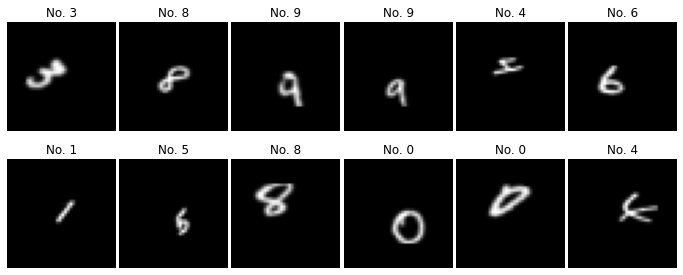

Validation acc over epoch 50: 0.8447385430335999
Validation Cost after epoch 50: 1.580914
Start of epoch 51
Training loss (for one batch) at step 0: 1.5577198266983032
Seen so far: 256 samples
Training loss (for one batch) at step 100: 1.5630435943603516
Seen so far: 25856 samples
Training loss (for one batch) at step 200: 1.5538843870162964
Seen so far: 51456 samples
Training acc over epoch 51: 0.8552507162094116
Training Cost after epoch 51: 1.555840
Validation acc over epoch 51: 0.8452756404876709
Validation Cost after epoch 51: 1.592206
Start of epoch 52
Training loss (for one batch) at step 0: 1.5463106632232666
Seen so far: 256 samples
Training loss (for one batch) at step 100: 1.5730829238891602
Seen so far: 25856 samples
Training loss (for one batch) at step 200: 1.5603781938552856
Seen so far: 51456 samples
Training acc over epoch 52: 0.8561897277832031
Training Cost after epoch 52: 1.556360
Validation acc over epoch 52: 0.8460754752159119
Validation Cost after epoch 52: 1.577

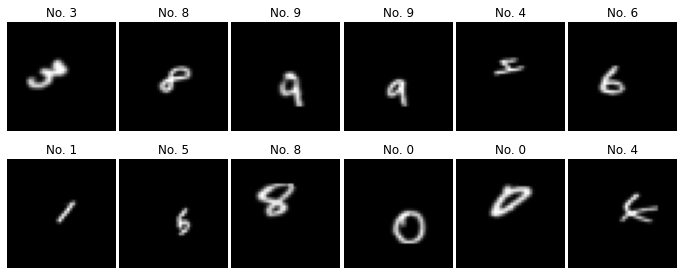

Validation acc over epoch 60: 0.850931704044342
Validation Cost after epoch 60: 1.579886
Start of epoch 61
Training loss (for one batch) at step 0: 1.5042378902435303
Seen so far: 256 samples
Training loss (for one batch) at step 100: 1.5779296159744263
Seen so far: 25856 samples
Training loss (for one batch) at step 200: 1.573551893234253
Seen so far: 51456 samples
Training acc over epoch 61: 0.8637974858283997
Training Cost after epoch 61: 1.550529
Validation acc over epoch 61: 0.8513951897621155
Validation Cost after epoch 61: 1.585680
Start of epoch 62
Training loss (for one batch) at step 0: 1.5457022190093994
Seen so far: 256 samples
Training loss (for one batch) at step 100: 1.5392999649047852
Seen so far: 25856 samples
Training loss (for one batch) at step 200: 1.5241329669952393
Seen so far: 51456 samples
Training acc over epoch 62: 0.8645920157432556
Training Cost after epoch 62: 1.547570
Validation acc over epoch 62: 0.8519232869148254
Validation Cost after epoch 62: 1.58092

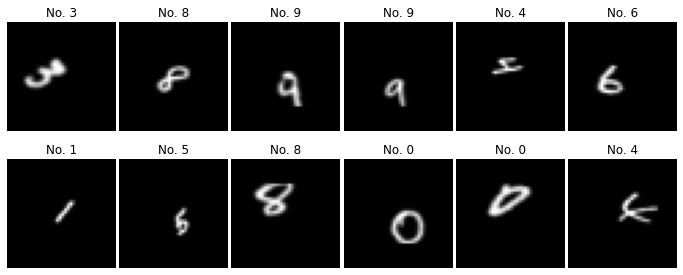

Validation acc over epoch 70: 0.8558943867683411
Validation Cost after epoch 70: 1.573712
Start of epoch 71
Training loss (for one batch) at step 0: 1.5158352851867676
Seen so far: 256 samples
Training loss (for one batch) at step 100: 1.5349011421203613
Seen so far: 25856 samples
Training loss (for one batch) at step 200: 1.5590181350708008
Seen so far: 51456 samples
Training acc over epoch 71: 0.8710632920265198
Training Cost after epoch 71: 1.541449
Validation acc over epoch 71: 0.856349527835846
Validation Cost after epoch 71: 1.577094
Start of epoch 72
Training loss (for one batch) at step 0: 1.5356948375701904
Seen so far: 256 samples
Training loss (for one batch) at step 100: 1.5321407318115234
Seen so far: 25856 samples
Training loss (for one batch) at step 200: 1.551404595375061
Seen so far: 51456 samples
Training acc over epoch 72: 0.8717049956321716
Training Cost after epoch 72: 1.543635
Validation acc over epoch 72: 0.8567671179771423
Validation Cost after epoch 72: 1.57854

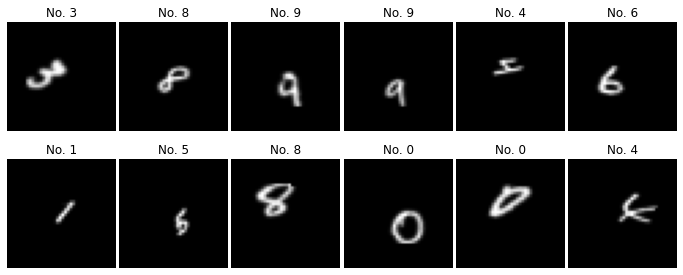

Validation acc over epoch 80: 0.8601337671279907
Validation Cost after epoch 80: 1.575217
Start of epoch 81
Training loss (for one batch) at step 0: 1.5121344327926636
Seen so far: 256 samples
Training loss (for one batch) at step 100: 1.562435269355774
Seen so far: 25856 samples
Training loss (for one batch) at step 200: 1.5491313934326172
Seen so far: 51456 samples
Training acc over epoch 81: 0.8772352933883667
Training Cost after epoch 81: 1.535997
Validation acc over epoch 81: 0.8606341481208801
Validation Cost after epoch 81: 1.564148
Start of epoch 82
Training loss (for one batch) at step 0: 1.5000529289245605
Seen so far: 256 samples
Training loss (for one batch) at step 100: 1.5755497217178345
Seen so far: 25856 samples
Training loss (for one batch) at step 200: 1.5551148653030396
Seen so far: 51456 samples
Training acc over epoch 82: 0.8778431415557861
Training Cost after epoch 82: 1.533807
Validation acc over epoch 82: 0.8610020279884338
Validation Cost after epoch 82: 1.5732

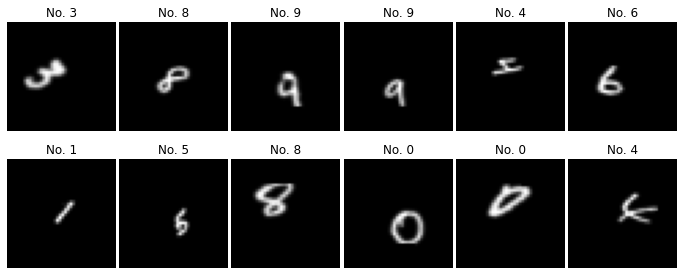

Validation acc over epoch 90: 0.8639249205589294
Validation Cost after epoch 90: 1.571843
Start of epoch 91
Training loss (for one batch) at step 0: 1.533798098564148
Seen so far: 256 samples
Training loss (for one batch) at step 100: 1.5543705224990845
Seen so far: 25856 samples
Training loss (for one batch) at step 200: 1.5197985172271729
Seen so far: 51456 samples
Training acc over epoch 91: 0.8827987313270569
Training Cost after epoch 91: 1.532019
Validation acc over epoch 91: 0.8642916679382324
Validation Cost after epoch 91: 1.567698
Start of epoch 92
Training loss (for one batch) at step 0: 1.519734501838684
Seen so far: 256 samples
Training loss (for one batch) at step 100: 1.5215712785720825
Seen so far: 25856 samples
Training loss (for one batch) at step 200: 1.505995273590088
Seen so far: 51456 samples
Training acc over epoch 92: 0.8833231925964355
Training Cost after epoch 92: 1.530031
Validation acc over epoch 92: 0.8646343946456909
Validation Cost after epoch 92: 1.568926

In [75]:
stn_model_reg_drop,train_cost_reg_drop,val_cost_reg_drop = train_STN(input_shape = input_shape, num_classes = num_classes, base_learning_rate=1e-2, batch_size = 256, num_epochs = 100, decay_rate = 0.09, l2_reg = 0.01, drop_rate = 0.2, batch_norm = 0, opti = 'adam', print_steps = 100, print_freq = 10)

Plot the costs for the model trained with regularization and dropout:

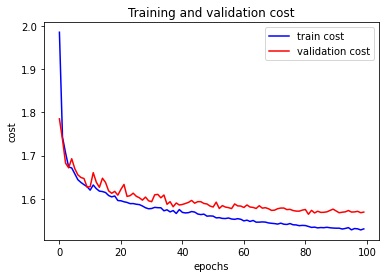

In [77]:
plot_costs(100,train_cost_reg_drop,val_cost_reg_drop,"costs_w_reg_drop")

Train the model with batch normalization and SGD optimizer:

Start of epoch 0
Training loss (for one batch) at step 0: 2.2923707962036133
Seen so far: 256 samples
Training loss (for one batch) at step 100: 2.2327499389648438
Seen so far: 25856 samples
Training loss (for one batch) at step 200: 2.203064441680908
Seen so far: 51456 samples
Training acc over epoch 0: 0.20683333277702332
Training Cost after epoch 0: 2.238951
Inputs after transformation after epoch 0 :



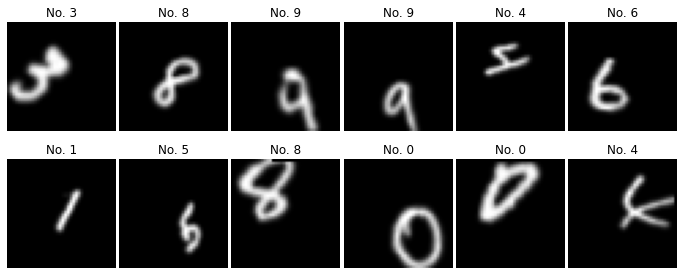

Validation acc over epoch 0: 0.27000001072883606
Validation Cost after epoch 0: 2.198817
Start of epoch 1
Training loss (for one batch) at step 0: 2.21390700340271
Seen so far: 256 samples
Training loss (for one batch) at step 100: 2.1843886375427246
Seen so far: 25856 samples
Training loss (for one batch) at step 200: 2.1736598014831543
Seen so far: 51456 samples
Training acc over epoch 1: 0.25320369005203247
Training Cost after epoch 1: 2.165406
Validation acc over epoch 1: 0.30391666293144226
Validation Cost after epoch 1: 2.143385
Start of epoch 2
Training loss (for one batch) at step 0: 2.1435930728912354
Seen so far: 256 samples
Training loss (for one batch) at step 100: 2.0919198989868164
Seen so far: 25856 samples
Training loss (for one batch) at step 200: 2.0873615741729736
Seen so far: 51456 samples
Training acc over epoch 2: 0.2908271551132202
Training Cost after epoch 2: 2.112306
Validation acc over epoch 2: 0.3312777876853943
Validation Cost after epoch 2: 2.099394
Start o

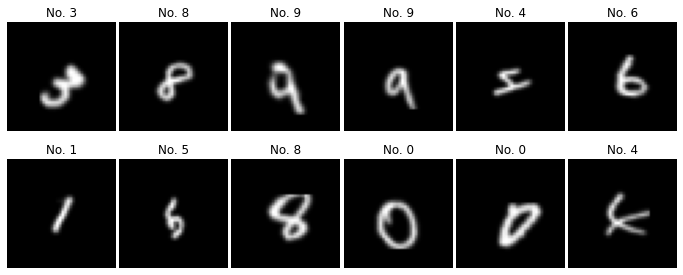

Validation acc over epoch 10: 0.6116969585418701
Validation Cost after epoch 10: 1.641579
Start of epoch 11
Training loss (for one batch) at step 0: 1.611250638961792
Seen so far: 256 samples
Training loss (for one batch) at step 100: 1.6287128925323486
Seen so far: 25856 samples
Training loss (for one batch) at step 200: 1.5964933633804321
Seen so far: 51456 samples
Training acc over epoch 11: 0.6120478510856628
Training Cost after epoch 11: 1.616235
Validation acc over epoch 11: 0.633222222328186
Validation Cost after epoch 11: 1.630265
Start of epoch 12
Training loss (for one batch) at step 0: 1.6232532262802124
Seen so far: 256 samples
Training loss (for one batch) at step 100: 1.5825917720794678
Seen so far: 25856 samples
Training loss (for one batch) at step 200: 1.6108686923980713
Seen so far: 51456 samples
Training acc over epoch 12: 0.6334202289581299
Training Cost after epoch 12: 1.605110
Validation acc over epoch 12: 0.6521538496017456
Validation Cost after epoch 12: 1.62115

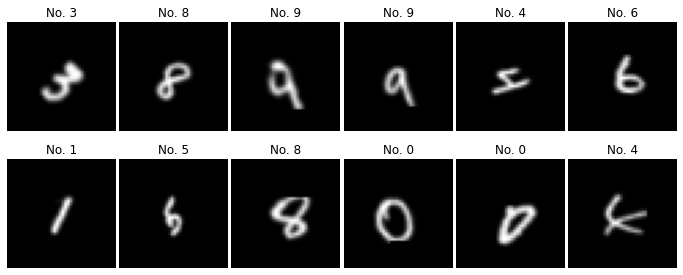

Validation acc over epoch 20: 0.7445317506790161
Validation Cost after epoch 20: 1.584108
Start of epoch 21
Training loss (for one batch) at step 0: 1.551302433013916
Seen so far: 256 samples
Training loss (for one batch) at step 100: 1.5573694705963135
Seen so far: 25856 samples
Training loss (for one batch) at step 200: 1.5633747577667236
Seen so far: 51456 samples
Training acc over epoch 21: 0.748668372631073
Training Cost after epoch 21: 1.557399
Validation acc over epoch 21: 0.7518484592437744
Validation Cost after epoch 21: 1.581505
Start of epoch 22
Training loss (for one batch) at step 0: 1.5642503499984741
Seen so far: 256 samples
Training loss (for one batch) at step 100: 1.567197561264038
Seen so far: 25856 samples
Training loss (for one batch) at step 200: 1.5460841655731201
Seen so far: 51456 samples
Training acc over epoch 22: 0.7565281987190247
Training Cost after epoch 22: 1.554736
Validation acc over epoch 22: 0.7586086988449097
Validation Cost after epoch 22: 1.577960

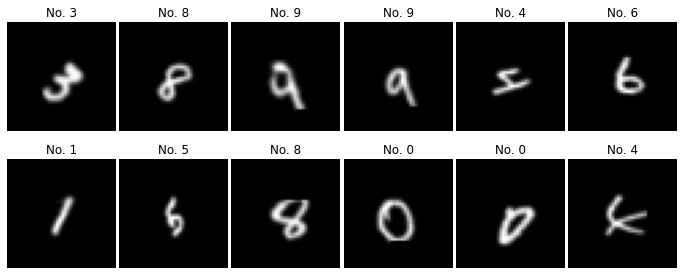

Validation acc over epoch 30: 0.7988440990447998
Validation Cost after epoch 30: 1.564069
Start of epoch 31
Training loss (for one batch) at step 0: 1.5371702909469604
Seen so far: 256 samples
Training loss (for one batch) at step 100: 1.5218666791915894
Seen so far: 25856 samples
Training loss (for one batch) at step 200: 1.5330005884170532
Seen so far: 51456 samples
Training acc over epoch 31: 0.807396411895752
Training Cost after epoch 31: 1.538194
Validation acc over epoch 31: 0.8024791479110718
Validation Cost after epoch 31: 1.565539
Start of epoch 32
Training loss (for one batch) at step 0: 1.544722080230713
Seen so far: 256 samples
Training loss (for one batch) at step 100: 1.5413293838500977
Seen so far: 25856 samples
Training loss (for one batch) at step 200: 1.5352272987365723
Seen so far: 51456 samples
Training acc over epoch 32: 0.8115179538726807
Training Cost after epoch 32: 1.537058
Validation acc over epoch 32: 0.8059242367744446
Validation Cost after epoch 32: 1.56375

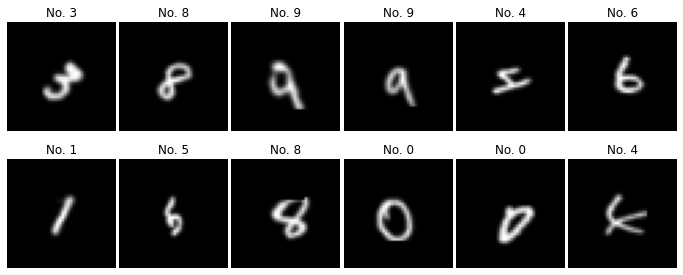

Validation acc over epoch 40: 0.8284755945205688
Validation Cost after epoch 40: 1.556895
Start of epoch 41
Training loss (for one batch) at step 0: 1.534452199935913
Seen so far: 256 samples
Training loss (for one batch) at step 100: 1.5395410060882568
Seen so far: 25856 samples
Training loss (for one batch) at step 200: 1.499975562095642
Seen so far: 51456 samples
Training acc over epoch 41: 0.8409096002578735
Training Cost after epoch 41: 1.527715
Validation acc over epoch 41: 0.8307262063026428
Validation Cost after epoch 41: 1.557376
Start of epoch 42
Training loss (for one batch) at step 0: 1.549300193786621
Seen so far: 256 samples
Training loss (for one batch) at step 100: 1.5389792919158936
Seen so far: 25856 samples
Training loss (for one batch) at step 200: 1.5250253677368164
Seen so far: 51456 samples
Training acc over epoch 42: 0.8435107469558716
Training Cost after epoch 42: 1.526854
Validation acc over epoch 42: 0.8328410983085632
Validation Cost after epoch 42: 1.558610

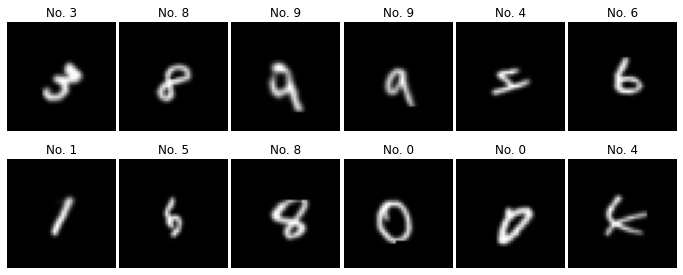

Validation acc over epoch 50: 0.847248375415802
Validation Cost after epoch 50: 1.554058
Start of epoch 51
Training loss (for one batch) at step 0: 1.5466831922531128
Seen so far: 256 samples
Training loss (for one batch) at step 100: 1.5310630798339844
Seen so far: 25856 samples
Training loss (for one batch) at step 200: 1.523754358291626
Seen so far: 51456 samples
Training acc over epoch 51: 0.8629074096679688
Training Cost after epoch 51: 1.520773
Validation acc over epoch 51: 0.848766028881073
Validation Cost after epoch 51: 1.552353
Start of epoch 52
Training loss (for one batch) at step 0: 1.510692834854126
Seen so far: 256 samples
Training loss (for one batch) at step 100: 1.5243797302246094
Seen so far: 25856 samples
Training loss (for one batch) at step 200: 1.5263965129852295
Seen so far: 51456 samples
Training acc over epoch 52: 0.8647065162658691
Training Cost after epoch 52: 1.520358
Validation acc over epoch 52: 0.8501980900764465
Validation Cost after epoch 52: 1.554468


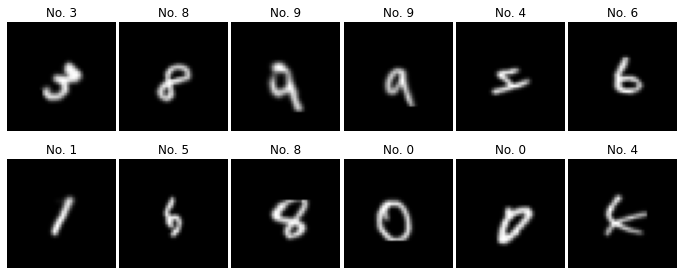

Validation acc over epoch 60: 0.8603333234786987
Validation Cost after epoch 60: 1.550814
Start of epoch 61
Training loss (for one batch) at step 0: 1.5143133401870728
Seen so far: 256 samples
Training loss (for one batch) at step 100: 1.5224766731262207
Seen so far: 25856 samples
Training loss (for one batch) at step 200: 1.5302578210830688
Seen so far: 51456 samples
Training acc over epoch 61: 0.8785657286643982
Training Cost after epoch 61: 1.516020
Validation acc over epoch 61: 0.8614811897277832
Validation Cost after epoch 61: 1.548498
Start of epoch 62
Training loss (for one batch) at step 0: 1.5090911388397217
Seen so far: 256 samples
Training loss (for one batch) at step 100: 1.517756700515747
Seen so far: 25856 samples
Training loss (for one batch) at step 200: 1.5033326148986816
Seen so far: 51456 samples
Training acc over epoch 62: 0.8798977136611938
Training Cost after epoch 62: 1.515281
Validation acc over epoch 62: 0.862589955329895
Validation Cost after epoch 62: 1.54846

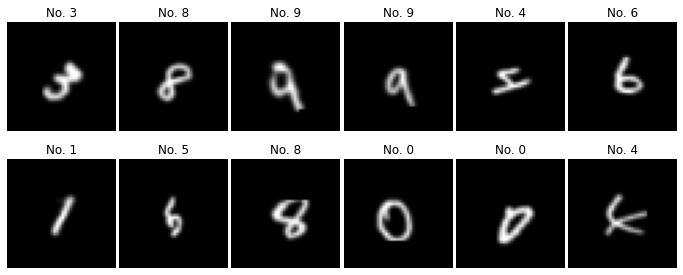

Validation acc over epoch 70: 0.8702206611633301
Validation Cost after epoch 70: 1.546965
Start of epoch 71
Training loss (for one batch) at step 0: 1.501107096672058
Seen so far: 256 samples
Training loss (for one batch) at step 100: 1.5064834356307983
Seen so far: 25856 samples
Training loss (for one batch) at step 200: 1.5209485292434692
Seen so far: 51456 samples
Training acc over epoch 71: 0.8903922438621521
Training Cost after epoch 71: 1.512531
Validation acc over epoch 71: 0.8710625171661377
Validation Cost after epoch 71: 1.548142
Start of epoch 72
Training loss (for one batch) at step 0: 1.5196856260299683
Seen so far: 256 samples
Training loss (for one batch) at step 100: 1.5109872817993164
Seen so far: 25856 samples
Training loss (for one batch) at step 200: 1.5201606750488281
Seen so far: 51456 samples
Training acc over epoch 72: 0.8914163112640381
Training Cost after epoch 72: 1.511853
Validation acc over epoch 72: 0.8718926906585693
Validation Cost after epoch 72: 1.5470

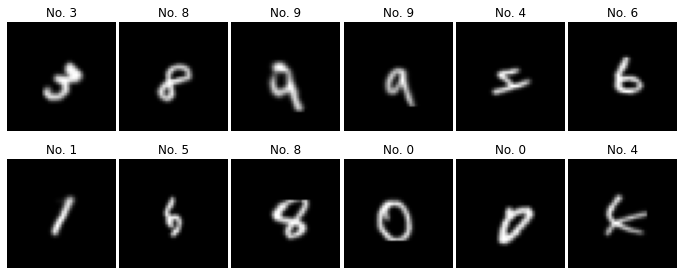

Validation acc over epoch 80: 0.8778066039085388
Validation Cost after epoch 80: 1.546162
Start of epoch 81
Training loss (for one batch) at step 0: 1.523168683052063
Seen so far: 256 samples
Training loss (for one batch) at step 100: 1.497401237487793
Seen so far: 25856 samples
Training loss (for one batch) at step 200: 1.5002987384796143
Seen so far: 51456 samples
Training acc over epoch 81: 0.8996418118476868
Training Cost after epoch 81: 1.509189
Validation acc over epoch 81: 0.8784796595573425
Validation Cost after epoch 81: 1.546420
Start of epoch 82
Training loss (for one batch) at step 0: 1.511470079421997
Seen so far: 256 samples
Training loss (for one batch) at step 100: 1.5151069164276123
Seen so far: 25856 samples
Training loss (for one batch) at step 200: 1.5263643264770508
Seen so far: 51456 samples
Training acc over epoch 82: 0.9004587531089783
Training Cost after epoch 82: 1.508886
Validation acc over epoch 82: 0.8791285157203674
Validation Cost after epoch 82: 1.546420

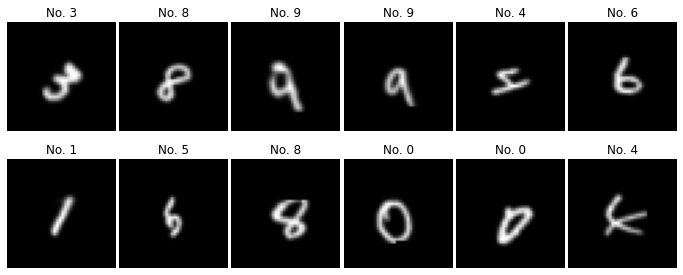

Validation acc over epoch 90: 0.8838827610015869
Validation Cost after epoch 90: 1.545147
Start of epoch 91
Training loss (for one batch) at step 0: 1.505902886390686
Seen so far: 256 samples
Training loss (for one batch) at step 100: 1.510164499282837
Seen so far: 25856 samples
Training loss (for one batch) at step 200: 1.518677830696106
Seen so far: 51456 samples
Training acc over epoch 91: 0.9071197509765625
Training Cost after epoch 91: 1.506713
Validation acc over epoch 91: 0.8844221234321594
Validation Cost after epoch 91: 1.544972
Start of epoch 92
Training loss (for one batch) at step 0: 1.5241360664367676
Seen so far: 256 samples
Training loss (for one batch) at step 100: 1.5203993320465088
Seen so far: 25856 samples
Training loss (for one batch) at step 200: 1.4941461086273193
Seen so far: 51456 samples
Training acc over epoch 92: 0.9077920913696289
Training Cost after epoch 92: 1.506560
Validation acc over epoch 92: 0.8849570155143738
Validation Cost after epoch 92: 1.544927

In [81]:
stn_model_sgd_bn,train_cost_sgd_bn,val_cost_sgd_bn = train_STN(input_shape = input_shape, num_classes = num_classes, base_learning_rate=1e-2, batch_size = 256, num_epochs = 100, decay_rate = 0.09, l2_reg = 0.00, drop_rate = 0.0, batch_norm = 1, opti = 'sgd', print_steps = 100, print_freq = 10)

Plot the costs for the model trained with batch normalization and SGD optimizer:

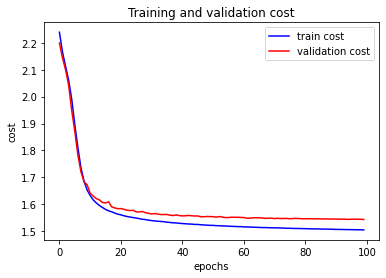

In [93]:
plot_costs(100,train_cost_sgd_bn,val_cost_sgd_bn,"costs_w_sgd_bn")

Train the model with SGD optimizer with reg and dropout:

Start of epoch 0
Training loss (for one batch) at step 0: 2.302957534790039
Seen so far: 256 samples
Training loss (for one batch) at step 100: 2.3022103309631348
Seen so far: 25856 samples
Training loss (for one batch) at step 200: 2.3019015789031982
Seen so far: 51456 samples
Training acc over epoch 0: 0.10053703933954239
Training Cost after epoch 0: 2.303214
Inputs after transformation after epoch 0 :



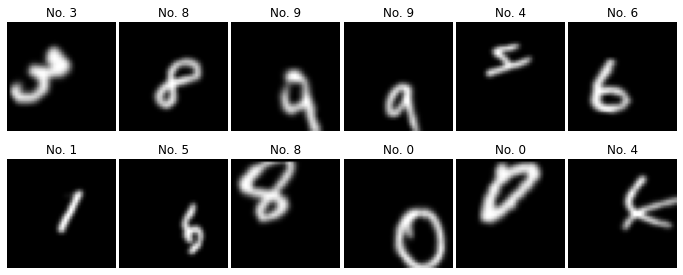

Validation acc over epoch 0: 0.1106666699051857
Validation Cost after epoch 0: 2.308524
Start of epoch 1
Training loss (for one batch) at step 0: 2.3022546768188477
Seen so far: 256 samples
Training loss (for one batch) at step 100: 2.3018548488616943
Seen so far: 25856 samples
Training loss (for one batch) at step 200: 2.3019044399261475
Seen so far: 51456 samples
Training acc over epoch 1: 0.10264814645051956
Training Cost after epoch 1: 2.303068
Validation acc over epoch 1: 0.1119166687130928
Validation Cost after epoch 1: 2.308409
Start of epoch 2
Training loss (for one batch) at step 0: 2.3024096488952637
Seen so far: 256 samples
Training loss (for one batch) at step 100: 2.302161693572998
Seen so far: 25856 samples
Training loss (for one batch) at step 200: 2.302361249923706
Seen so far: 51456 samples
Training acc over epoch 2: 0.10435184836387634
Training Cost after epoch 2: 2.302956
Validation acc over epoch 2: 0.11427778005599976
Validation Cost after epoch 2: 2.308304
Start o

RuntimeError: ignored

In [113]:
stn_model_sgd,train_cost_sgd_reg,val_cost_sgd=train_STN(input_shape = input_shape, num_classes = num_classes, base_learning_rate=1e-2, batch_size = 256, num_epochs = 100, decay_rate = 0.09, l2_reg = 0.01, drop_rate = 0.2, batch_norm = 0, opti = 'sgd', print_steps = 100, print_freq = 10)